In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28)

# the data, split between train and test sets

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train = keras.utils.normalize(x_train, axis = 1)
x_test = keras.utils.normalize(x_test, axis = 1)


print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print("y_train shape:", y_train.shape)
print(y_train[0])


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
y_train shape: (60000,)
5


In [3]:
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [4]:
# Define our model
model = keras.Sequential()

model.add(layers.Flatten(input_shape=input_shape))

model.add(layers.Dense(units = 100, activation = "relu"))

model.add(layers.Dense(units = 100, activation = "relu"))

model.add(layers.Dense(units = 10, activation = "softmax"))

model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import keras.backend as K

# defining a new metric that will be displayed during the fitting
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


batch_size = 128
epochs = 30

# compiling the model we previously defined
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", f1_metric])

# training the model
history_adam = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [6]:
# model.save("./models/mlp_mnist")

In [7]:
# Evaluating the performance of the model on the test set
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1459474414587021
Test accuracy: 0.9735999703407288


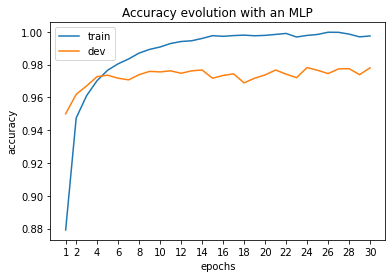

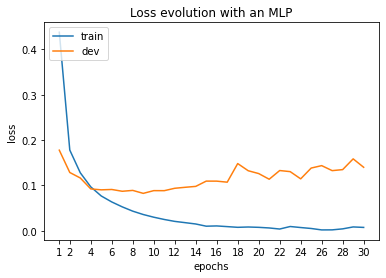

In [8]:
# Plotting the evolution of the accuracy, F1 score and loss of the model on the training and dev set throughout the training
epochs = [i for i in range(1,31)]
epochs_ticks = [i for i in range(1,31) if i%2==0 or i==1]# Accuracy
fig1, ax1 = plt.subplots()
ax1.set_xticks(epochs_ticks)
plt.plot(epochs, history_adam.history["accuracy"])
plt.plot(epochs, history_adam.history["val_accuracy"])
plt.title("Accuracy evolution with an MLP")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "dev"], loc = "upper left")
plt.show()

# # F1 Score
# fig2, ax2 = plt.subplots()
# ax2.set_xticks(epochs_ticks)
# plt.plot(epochs, history_adam.history["f1_metric"])
# plt.plot(epochs, history_adam.history["val_f1_metric"])
# plt.title("Model F1 score")
# plt.ylabel("F1 Score")
# plt.xlabel("epochs")
# plt.legend(["train", "dev"], loc = "upper left")
# plt.show()

# Loss
fig3, ax3 = plt.subplots()
ax3.set_xticks(epochs_ticks)
plt.plot(epochs, history_adam.history["loss"])
plt.plot(epochs, history_adam.history["val_loss"])
plt.title("Loss evolution with an MLP")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "dev"], loc = "upper left")
plt.show()

In [10]:
# Loading a model from a file
modelBefore = keras.models.load_model('./models/mlp_mnist', custom_objects={"f1_metric":f1_metric})
score = modelBefore.evaluate(x_test, y_test, verbose=0)
# Evaluating the model to get a baseline before changing the weights and biases after quantizing them
print("Before changing the weights and biases")
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Before changing the weights and biases
Test loss: 0.13589470088481903
Test accuracy: 0.9749000072479248


In [11]:
# Defining a function that creates a new model, copies the parameters of a given model
# Then, quantizes the parameters of this new model using a precision in bits

def change_precision_of_model(model, precision, inputs, labels):
    # initializing to an empty array the array we will will set to weights to
    tmp_model= keras.models.clone_model(model)
    tmp_model.build(input_shape)
    tmp_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", f1_metric])
    tmp_model.set_weights(model.get_weights())
    
    weights_and_biases = []
    # print(modelBefore.get_weights()[0][0][0:3])
    for i in range(len(tmp_model.get_weights())):
        matrix = tmp_model.get_weights()[i]
        # pair indexes correspond to the weight matrices and odd indexes correspond to bias matrices
        # as bias matrices are only of 1 column and weights matrices have multiple columns, we have to treat them differently
        # if biases
        if (i+1)%2 == 0:
            changedPrecision = np.floor(matrix * 2**precision) / (2**(precision))
            weights_and_biases.append(changedPrecision)
        # if weights
        else:
            changed_weights = []
            for item in matrix:
                changed_item = np.floor(item * 2**precision) / (2**(precision))
                changed_weights.append(changed_item)
            weights_and_biases.append(np.array(changed_weights))

    # change weights to the new ones we computed
    tmp_model.set_weights(weights_and_biases)
    score = tmp_model.evaluate(inputs, labels, verbose=0)
    return score


# Evaluating the baseline model
score = model.evaluate(x_test, y_test, verbose=0)
print("After changing the weights and biases to float16")
print("Test loss:", score[0])
print("Test accuracy:", score[1])


After changing the weights and biases to float16
Test loss: 0.1459474414587021
Test accuracy: 0.9735999703407288


In [12]:
# Evaluating different models depending on their precision

print("Loss \t Accuracy \t F1 Score")
print(model.evaluate(x_test, y_test, verbose=0))
print(change_precision_of_model(model, 32, x_test, y_test))
print(change_precision_of_model(model, 16, x_test, y_test))
print(change_precision_of_model(model, 8, x_test, y_test))
print(change_precision_of_model(model, 4, x_test, y_test))
print(change_precision_of_model(model, 32, x_test, y_test))

Loss 	 Accuracy 	 F1 Score
[0.1459474414587021, 0.9735999703407288, 0.9739082455635071]
[0.1459474414587021, 0.9735999703407288, 0.9739082455635071]
[0.14589567482471466, 0.9735999703407288, 0.9739082455635071]
[0.13501060009002686, 0.973800003528595, 0.9740588665008545]
[0.8302320241928101, 0.7559999823570251, 0.6522641181945801]
[0.1459474414587021, 0.9735999703407288, 0.9739082455635071]


In [13]:
# Defining a function that makes it easier to plot the graphs of a model

def make_figures(losses, losses_test, accuracies, accuracies_test, F1_scores, F1_scores_test, loss_fig = True, acc_fig = True, F1_fig = True):
    if loss_fig:
        precisions = [precision for precision in range(2,34,2)]
        precisions.insert(3,7)
        print(precisions)
        fig, ax = plt.subplots()
        plt.plot(precisions, losses)
        plt.plot(precisions, losses_test)
        plt.title("Loss of the Model w/r to the word length")
        plt.ylabel("loss")
        plt.xlabel("word length")
        plt.legend(["training set loss", "test set loss"], loc = "upper right")
        ax.set_xticks(precisions)
        plt.show()

    if acc_fig:
        fig, ax2 = plt.subplots()
        plt.plot(precisions, accuracies)
        plt.plot(precisions, accuracies_test)
        plt.title("Accuracy of the Model w/r to the word length")
        plt.ylabel("accuracy")
        plt.xlabel("word length")
        plt.legend(["training set accuracy", "test set accuracy"], loc = "lower right")
        ax2.set_xticks(precisions)
        plt.show()

    if F1_fig:
        fig, ax3 = plt.subplots()
        plt.plot(precisions, F1_scores)
        plt.plot(precisions, F1_scores_test)
        plt.title("F1 scores of the Model w/r to the word length")
        plt.ylabel("F1 score")
        plt.xlabel("word length")
        plt.legend(["training set F1 score", "test set F1 score"], loc = "lower right")
        ax3.set_xticks(precisions)
        plt.show()

In [14]:
# Creating multiples models depending on the precision (ranging from 2 to 32 bits)
# Then appending the results of each model to arrays to then plot figures of the results

losses = []
accuracies = []
F1_scores = []
losses_test = []
accuracies_test = []
F1_scores_test = []
for precision in range(2,34,2):
    # Returns the score of this specific model
    score = change_precision_of_model(model, precision, x_train, y_train)
    loss = score[0]
    accuracy = score[1]
    F1_score = score[2]
    losses.append(loss), accuracies.append(accuracy), F1_scores.append(F1_score)
    # Try returning only model in change precision function that way no need to do it twice, we'll just evaluate on the training then test set
    score_test = change_precision_of_model(model, precision, x_test, y_test)
    loss_test = score_test[0]
    accuracy_test = score_test[1]
    F1_score_test = score_test[2]
    losses_test.append(loss_test), accuracies_test.append(accuracy_test), F1_scores_test.append(F1_score_test)
    if precision == 6:
        score = change_precision_of_model(model, 7, x_train, y_train)
        loss = score[0]
        accuracy = score[1]
        F1_score = score[2]
        losses.append(loss), accuracies.append(accuracy), F1_scores.append(F1_score)

        score_test = change_precision_of_model(model, 7, x_test, y_test)
        loss_test = score_test[0]
        accuracy_test = score_test[1]
        F1_score_test = score_test[2]
        losses_test.append(loss_test), accuracies_test.append(accuracy_test), F1_scores_test.append(F1_score_test)
        

[2, 4, 6, 7, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]


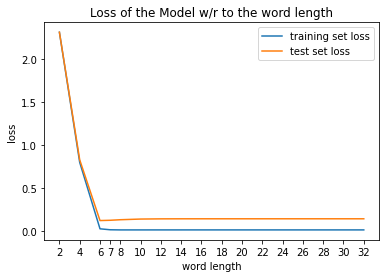

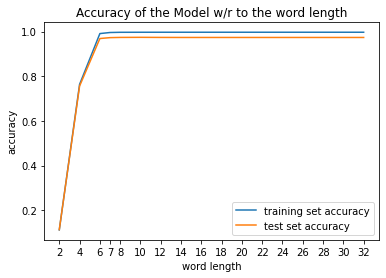

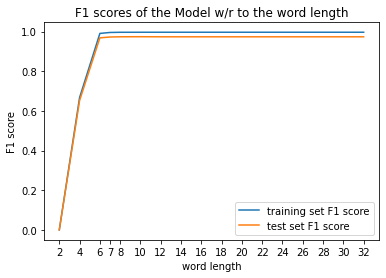

In [15]:
# Plot figures showing the impact of the word length (precision)
# Testing the robustness of a model to parameter quantization

make_figures(losses, losses_test, accuracies, accuracies_test, F1_scores, F1_scores_test)

In [17]:
modelBefore = keras.models.load_model('./models/mlp_mnist', custom_objects={"f1_metric":f1_metric})
score = modelBefore.evaluate(x_test, y_test, verbose=0)
print("Before changing the weights and biases")
print("Test loss:", score[0])
print("Test accuracy:", score[1])
# 
# Test loss: 0.1115352064371109
# Test accuracy: 0.9708999991416931

Before changing the weights and biases
Test loss: 0.13589470088481903
Test accuracy: 0.9749000072479248


In [18]:
def plotGraphics(history_given, optimizer, max_epoch):
    epochs = [epoch for epoch in range(max_epoch+1)]
    fig, ax1 = plt.subplots()
    plt.plot(history_given.history["accuracy"])
    plt.plot(history_given.history["val_accuracy"])
    plt.title("Model with " + optimizer +   ": Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend(["train", "dev"], loc = "upper left")
    ax1.set_xticks(epochs)
    plt.show()

    fig, ax2 = plt.subplots()
    plt.plot(history_given.history["f1_metric"])
    plt.plot(history_given.history["val_f1_metric"])
    plt.title("Model F1 score")
    plt.ylabel("F1 Score")
    plt.xlabel("epochs")
    plt.legend(["train", "dev"], loc = "upper left")
    ax2.set_xticks(epochs)
    plt.show()

    fig, ax3 = plt.subplots()
    plt.plot(history_given.history["loss"])
    plt.plot(history_given.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("epochs")
    plt.legend(["train", "dev"], loc = "upper left")
    ax3.set_xticks(epochs)
    plt.show()

In [19]:
# plotGraphics(history_gd, "Gradient Descent", epochs)
# plotGraphics(history_adam, "Adam", epochs)
# plotGraphics(history_mom, "Momentum", epochs)

In [20]:
# Quantizing our previous model using keras tools
# More specifically, using quantization aware as we will fine tune the quantized model later on as we are in possession of the dataset we are working on
# Default quantization is to 8-bits integers so this operation lets us reduces the memory used by our model by around 4 (32 bits float to 8bits integers67)

import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
# using the initial model made and fine tuning it
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy', f1_metric])

# Summary to get informations on layers, parameters etc...
q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 28, 28)           3         
 er)                                                             
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 100)              10105     
 perV2)                                                          
                                                                 
 quant_dense_2 (QuantizeWrap  (None, 10)               1

In [ ]:
# Fine tuning our new quantized model using only a portion of the training set we have

train_images_subset = x_train[0:10000] # out of 60000
train_labels_subset = y_train[0:10000]

# quantization-aware model which means we will do fine tuning by training this new model after having changed the weights and baises representation
q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=128, epochs=4, validation_split=0.1)

In [22]:
# Evaluating the performance of our baseline model against the quantized model after fine tuning

evaluation_basic_model = model.evaluate(
    x_test, y_test, verbose=0)

evaluation_q_model = q_aware_model.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', evaluation_basic_model[1])
print('Quantized test accuracy:', evaluation_q_model[1])

Baseline test accuracy: 0.9735999703407288
Quantized test accuracy: 0.9729999899864197
